In [1]:
import os
import paths
import numpy as np
import pandas as pd
import geopandas as gpd

from train_model import load_data
from apollo import mechanics as ma

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

# Enable Float64 for more stable matrix inversions.
from jax import config

config.update("jax_enable_x64", True)

from jax import jit
import jax.random as jr
import jax.numpy as jnp
from jaxtyping import install_import_hook
with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

import utils as ut
import optax as ox
from apollo import streamflow as strf
from apollo import metrics as me
    
key = jr.key(123)
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
import tensorflow_probability.substrates.jax as tfp

from docs.examples.utils import clean_legend

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))
plt.rc('text', usetex=False)
plt.rcParams['font.family'] = 'DeJavu Serif'

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", message="findfont: Font family")

C:\Users\aline\AppData\Local\Programs\Python\Python310\lib\site-packages\cola\backends\backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


### 1. Dataset

Output values are the streamflow prediction while the input, in first instance, is the precipitation.

In [139]:
station_nr = 33039

df = pd.read_csv('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_gdf.csv'))
name = df.loc[df.index[3]].iloc[2]
print('Processing site "', name, '"')
    
boundary = gpd.read_file('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '.shp'))
    
rf = load_data.load_data('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9_linear.csv'), verbose=False)

Processing site " Bedford Ouse at Roxton "


In [140]:
days = 6
features = (['Rain'] + ['Rain-' + f'{d+1}' for d in range(days)] \
        + ['Rain_28_Mu','Rain_90_Mu','Rain_180_Mu', 'Temperature_28_Mu','Temperature_90_Mu','Temperature_180_Mu']
            + ['Temperature'] + ['Temperature-' + f'{d+1}' for d in range(days)])
            #+ ['Resultant Windspeed'] \
            #+ ['Resultant Windspeed-' + f'{d+1}' for d in range(days)] \
            #+ ['Humidity'] + ['Humidity-' + f'{d+1}' for d in range(days)])
            #"+ ['Soil Moisture ' + f'{i+1}' for i in range(4)]
#features = (['Rain'] + ['Rain-' + f'{d+1}' for d in range(days)])
print(len(features))

20


In [141]:
import importlib
importlib.reload(load_data)

<module 'train_model.load_data' from 'C:\\Users\\aline\\soil-moisture-proxies\\train_model\\load_data.py'>

In [142]:
years_eval = [2010 + i for i in range(12)]
#years_train = [1982,1983, 1991,1993,1997,2000]
years_train = [1982,1983, 1985, 1989, 1991,1993,1994,1997,2000, 2004, 2005, 2008]

# LOAD DATA
testrf = rf[pd.to_datetime(rf['Date']).dt.year.isin(years_eval)]
trnset, full_set = load_data.preprocess_data(rf, features, years_eval)
print(len(trnset))
targets = ['Flow']
xspace = ma.featurelocator(rf, features)
yspace = ma.featurelocator(rf, targets)

# TRAINING
x_train = load_data.reshape_input(trnset, xspace)
y_train = load_data.reshape_output(trnset, yspace)
y_full = load_data.reshape_input(full_set, xspace)

# Keep test set always the same
test_set = full_set[-len(testrf):, :]

y_scaler = StandardScaler().fit(y_train)
standardised_train_y = y_scaler.transform(y_train)

# Turn it into a GPJax Dataset
D = gpx.Dataset(X=jnp.array(x_train, dtype=jnp.float64), y=jnp.array(standardised_train_y, dtype=jnp.float64))
        
xtest = load_data.reshape_input(test_set, xspace)
ytest = load_data.reshape_output(test_set, yspace)
standardised_test_y = y_scaler.transform(ytest)

xfull = load_data.reshape_input(full_set, xspace)
yfull = load_data.reshape_output(full_set, yspace)
standardised_full_y = y_scaler.transform(yfull)

10991


In [143]:
print(len(xtest))

4377


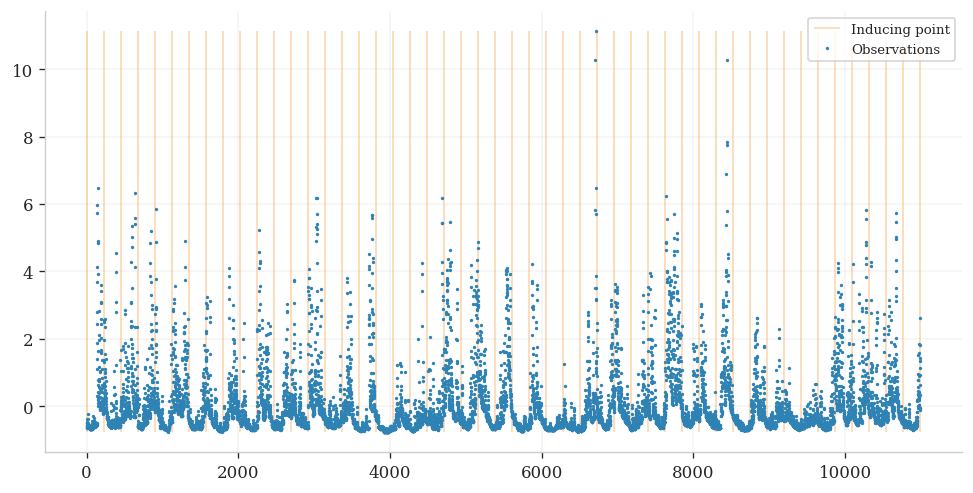

In [144]:
x_indices = np.arange(x_train.shape[0])

z = jnp.linspace(x_indices.min(), x_indices.max(), 50).reshape(-1, 1)

colors = ['lightblue', 'darkseagreen']

fig, ax = plt.subplots(figsize=(8,4))
ax.vlines(
    z,
    ymin=standardised_train_y.min(),
    ymax=standardised_train_y.max(),
    alpha=0.3,
    linewidth=1,
    label="Inducing point",
    color=cols[2],
)

ax.plot(x_indices, standardised_train_y, "o", label="Observations", color=cols[0], markersize=1)
#ax.plot(x_train, y_train, label="Latent function", color=cols[1])
ax.legend(loc="best")
plt.show()

### 2. Prior

In [177]:
tfb = tfp.bijectors

dimensions = np.arange(len(features)).tolist()

softclip_low = jnp.array(1e-5, dtype=jnp.float64)
softclip_high_var = jnp.array(1e4, dtype=jnp.float64)
softclip_high_ls = jnp.array(1e2, dtype=jnp.float64)

#prior_lengthscales = [2.02,1.37,1.21,1.65,2.22,0.63,0.17,0.45,0.19,0.08,0.05,8.87,7.1,3.85,7.74,4.14]
prior_lengthscales = [0.71 for _ in range(len(features))]
lengthscale_array = jnp.array(prior_lengthscales, dtype=jnp.float64)

kernel_Matern = gpx.kernels.Matern32(active_dims=dimensions, lengthscale=lengthscale_array, variance=0.61)
kernel_Matern = kernel_Matern.replace_bijector(lengthscale=tfb.SoftClip(low=softclip_low, high=softclip_high_ls))
kernel_Matern = kernel_Matern.replace_bijector(variance=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=softclip_high_var))

kernel_Linear = gpx.kernels.Linear(active_dims=dimensions, variance=0.5)
kernel_Linear = kernel_Linear.replace_bijector(variance=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=softclip_high_var))

kernel_exp = gpx.kernels.PoweredExponential(active_dims=dimensions, lengthscale=0.72, variance=0.61)
kernel_exp = kernel_exp.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-5, dtype=jnp.float64)))
kernel_exp = kernel_exp.replace_bijector(variance=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e4, dtype=jnp.float64)))

# Define Rational Quadratic kernel for capturing varying smoothness
kernel_RationalQuadratic = gpx.kernels.RationalQuadratic(active_dims=dimensions, lengthscale=0.5, variance=1.0, alpha=1.0)
kernel_RationalQuadratic = kernel_RationalQuadratic.replace_bijector(lengthscale=tfb.SoftClip(low=softclip_low, high=softclip_high_ls))
kernel_RationalQuadratic = kernel_RationalQuadratic.replace_bijector(variance=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=softclip_high_var))

# White Noise kernel with a lower initial variance
kernel_WhiteNoise = gpx.kernels.White(active_dims=dimensions, variance=0.01)
kernel_WhiteNoise = kernel_WhiteNoise.replace_bijector(variance=tfb.SoftClip(low=jnp.array(1e-8, dtype=jnp.float64), high=jnp.array(1e4, dtype=jnp.float64)))

kernel_WhiteNoise1 = gpx.kernels.White(active_dims=dimensions, variance=0.01)
kernel_WhiteNoise1 = kernel_WhiteNoise1.replace_bijector(variance=tfb.SoftClip(low=jnp.array(1e-8, dtype=jnp.float64), high=jnp.array(1e4, dtype=jnp.float64)))

product_kernel = gpx.kernels.ProductKernel(kernels=[kernel_Matern, kernel_Linear, kernel_WhiteNoise])
kernel = gpx.kernels.SumKernel(kernels=[product_kernel, kernel_WhiteNoise1])

meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

In [178]:
# Prior distribution is the distribution without extra knowledge
xtest_oneyear = xtest[365:850]
prior_dist = prior.predict(xtest_oneyear)

# Distillate the mean and variance to be able to sample functions
prior_mean = prior_dist.mean()
prior_std = prior_dist.variance()
samples = prior_dist.sample(seed=key, sample_shape=(5,))
samples

Array([[-0.68581504, -0.73886332, -0.90114861, ..., -0.11249376,
        -0.59226332, -0.13483439],
       [-0.3682922 , -1.01183324, -0.71620866, ..., -0.58457274,
        -1.59023153, -0.38585868],
       [ 0.40032388,  0.26249362,  0.30960918, ...,  0.80902797,
         1.71891098,  2.39923512],
       [ 0.69140612,  0.18460146,  0.46736164, ...,  1.16099923,
         1.35409862,  0.80655444],
       [-0.53682116, -0.33463676,  0.00862219, ..., -0.45064651,
        -0.08248267,  0.17330109]], dtype=float64)

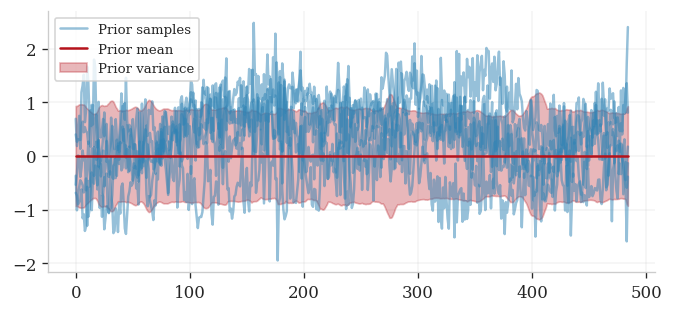

In [179]:
fig, ax = plt.subplots()
ax.plot(np.arange(xtest_oneyear.shape[0]), samples.T, alpha=0.5, color=cols[0], label="Prior samples")
ax.plot(np.arange(xtest_oneyear.shape[0]), prior_mean, color=cols[1], label="Prior mean")
ax.fill_between(
    np.arange(xtest_oneyear.shape[0]),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    color=cols[1],
    label="Prior variance",
)
ax.legend(loc="best")
ax = clean_legend(ax)

### 3. Posterior

In [180]:
# Choice for the value of obs_stddev
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=jnp.array([1.0], dtype=jnp.float64)) 
likelihood = likelihood.replace_bijector(obs_stddev=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64)))

posterior = prior * likelihood

### 3b. Introduction Sparse Stochastic Variational Inference

In [181]:
min_values = np.min(xfull, axis=0)
max_values = np.max(xfull, axis=0)

In [182]:
num_inducing_points = 150
num_dimensions = len(features)
inducing_points = [jr.uniform(key, shape=(num_inducing_points,), minval=min_values[i], maxval=max_values[i]) for i in range(num_dimensions)]
z = jnp.stack(inducing_points, axis=-1)
q = gpx.variational_families.VariationalGaussian(posterior=posterior, inducing_inputs=z)

inducing_points

[Array([ 0.4628935 ,  0.62076666,  0.77156808,  0.79594093,  0.62958517,
         0.91858897,  0.64920609,  0.69869252,  0.51833705,  0.15378219,
         0.59490025,  0.81741964,  0.07506025,  0.25713716,  0.89685374,
         0.23708192,  0.6125816 ,  0.8858376 ,  0.43101984,  0.68642791,
         0.80815315,  0.00180132,  0.35419064,  0.49281036,  0.00439966,
         0.36794712,  0.35161725,  0.34979615,  0.8831772 ,  0.76668352,
         0.90574205,  0.32374369,  0.07039957,  0.50415639,  0.94263843,
         0.69557459,  0.79213955,  0.67492893,  0.07252517,  0.60990358,
         0.83632724,  0.52511805,  0.89870214,  0.59456843,  0.13738438,
         0.22520125,  0.55564866,  0.22076584,  0.00213196,  0.84552195,
         0.79378784,  0.53305007,  0.08403931,  0.16090162, -0.01496492,
         0.36032337,  0.95234262,  0.66281678,  0.43783401,  0.77253588,
         0.63522874,  0.15795304,  0.72647614,  0.42317723,  0.53130727,
         0.57311948,  0.03721381,  0.46076421,  0.9

In [183]:
negative_elbo = gpx.objectives.ELBO(negative=True)
negative_elbo = jit(negative_elbo)

In [184]:
schedule = ox.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=0.01,
    warmup_steps=100,
    decay_steps=2000,
    end_value=0.001,
)

opt_posterior, history = gpx.fit(
    model=q,
    objective=negative_elbo,
    train_data=D,
    optim=ox.adam(learning_rate=schedule),
    num_iters=3000,
    key=jr.key(42),
    batch_size=128,
)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [185]:
opt_posterior

VariationalGaussian(posterior=ConjugatePosterior(prior=Prior(kernel=CombinationKernel(compute_engine=DenseKernelComputation(), active_dims=None, name='AbstractKernel', kernels=[Matern32(compute_engine=DenseKernelComputation(), active_dims=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], name='Matérn32', lengthscale=Array([3.09331277, 1.27706605, 0.85290595, 0.79659108, 1.01086061,
       1.40502714, 2.06203835, 1.3294505 , 2.22169471, 1.48817491,
       0.513617  , 4.63333002, 5.53013427, 2.96175727, 2.62558401,
       2.54462212, 3.23942968, 3.9404413 , 3.9039853 , 4.43641045],      dtype=float64), variance=Array(0.31124477, dtype=float64)), Linear(compute_engine=DenseKernelComputation(), active_dims=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], name='Linear', variance=Array(0.57193144, dtype=float64)), White(active_dims=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], name='White', variance=Array(0.00066981, dtyp

### 4. Parameters

In [ ]:
%%time
'''
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
#negative_mll(posterior, train_data=D)
negative_mll = jit(negative_mll)

opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=negative_mll,
    train_data=D,
    max_iters=1000,
)

print(opt_posterior.prior)
print(opt_posterior.likelihood)
'''

In [59]:
def predict_in_batches(model, xtest, train_data, batch_size=500):
    n = xtest.shape[0]
    predictive_means = []
    predictive_stds = []

    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        xtest_batch = xtest[start:end]

        # Perform prediction on the current batch
        latent_dist = model.predict(xtest_batch, train_data=train_data)
        predictive_dist = model.likelihood(latent_dist)
        
        #latent_dist = model(xtest_batch)
        #predictive_dist = model.posterior.likelihood(latent_dist)

        # Collect the means and standard deviations
        predictive_means.append(predictive_dist.mean().reshape(-1, 1))
        predictive_stds.append(predictive_dist.stddev().reshape(-1, 1))

    # Concatenate all the results
    predictive_mean = np.concatenate(predictive_means, axis=0)
    predictive_std = np.concatenate(predictive_stds, axis=0)

    return predictive_mean, predictive_std

In [396]:
batch_size = 500
predictive_mean, predictive_std = predict_in_batches(opt_posterior, xtest, train_data=D, batch_size=batch_size)

TypeError: got an unexpected keyword argument 'train_data'

In [186]:
latent_dist = opt_posterior(xtest)
predictive_dist = opt_posterior.posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean().reshape(-1, 1)
predictive_std = predictive_dist.stddev().reshape(-1, 1)
predictive_mean

Array([[2.86349803],
       [2.1420621 ],
       [1.19028821],
       ...,
       [2.71487909],
       [2.27708557],
       [1.41552789]], dtype=float64)

In [187]:
testrf['Predicted'] = y_scaler.inverse_transform(predictive_mean)
testrf['Sanity check'] = y_scaler.inverse_transform(np.array(standardised_test_y).reshape(-1,1))

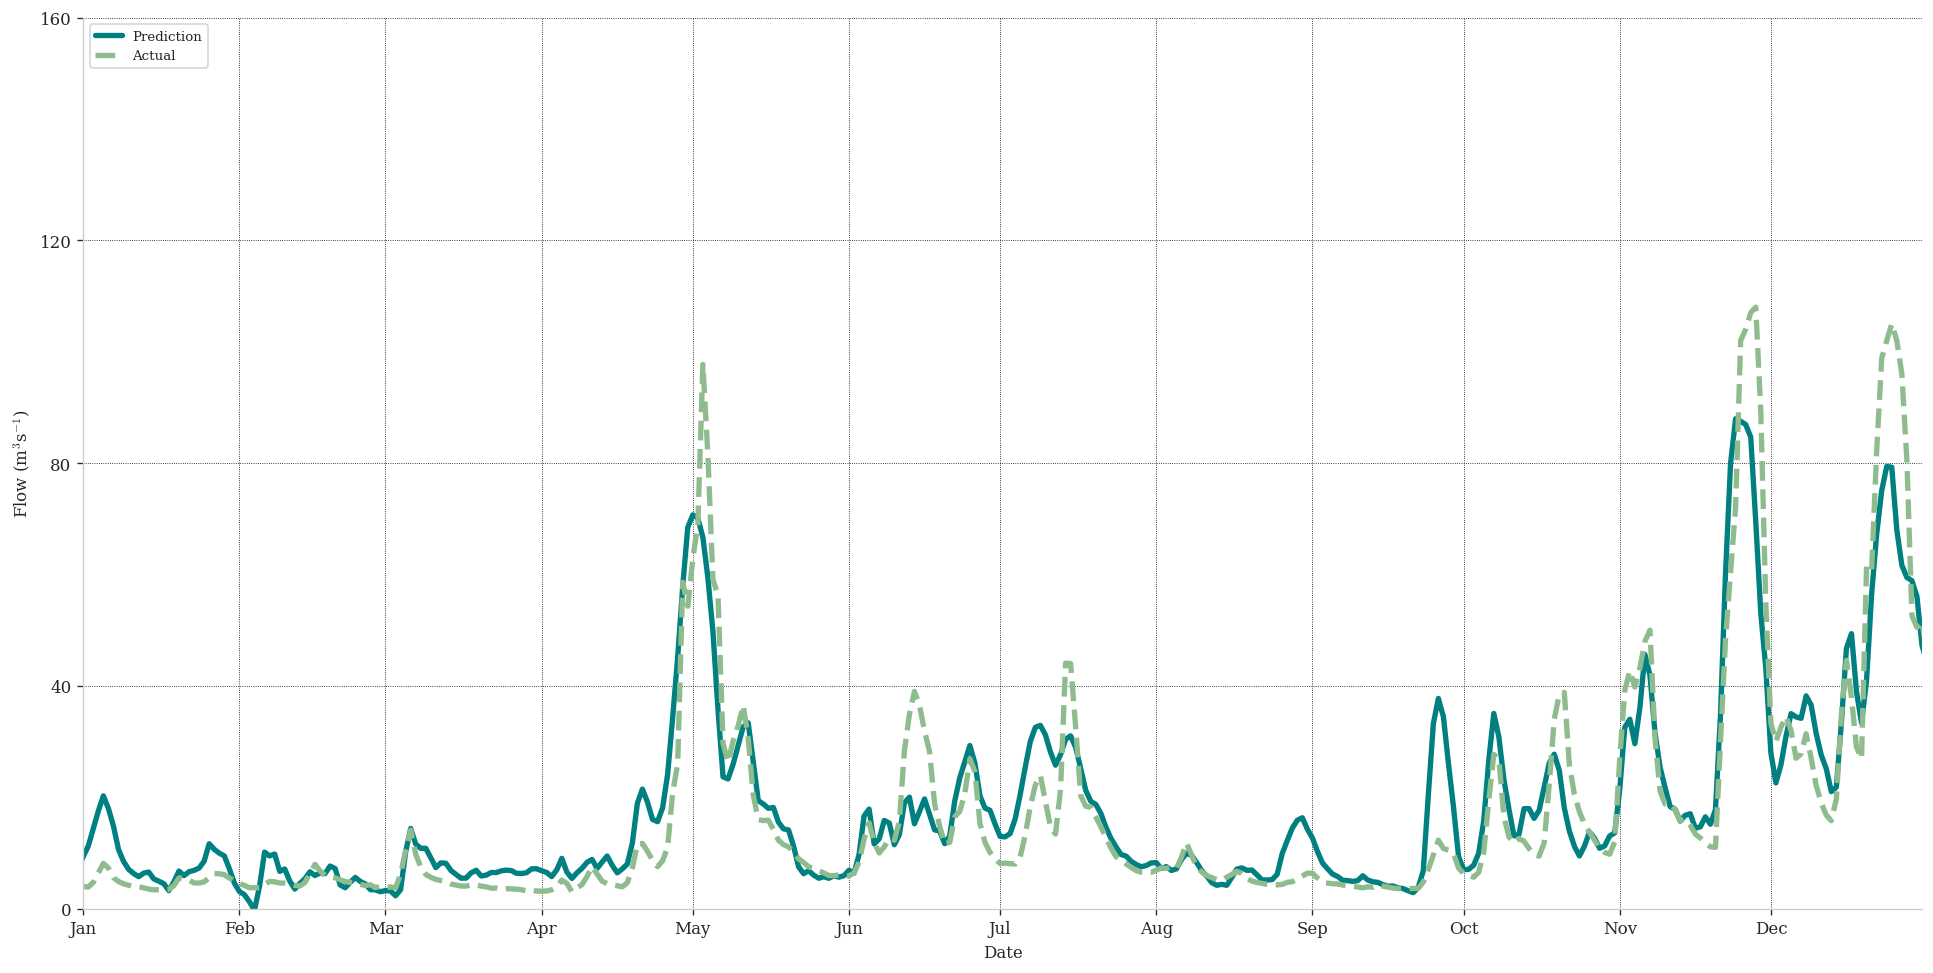

In [188]:
maxflow=160
strf.year_plot(testrf, 'Predicted', 'Flow', 2012, maxflow=maxflow)

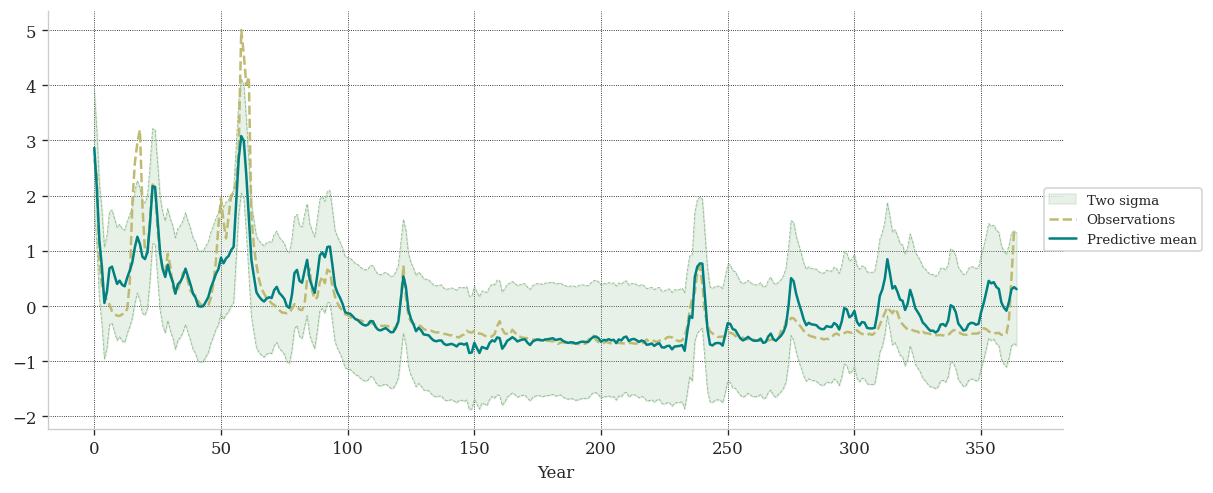

In [175]:
def plot_gp_results(x_train, xtest, y_train, y_test, pred_mean, pred_std=None, plot_train_data=False, plot_confidence=True, colour1='darkKhaki', colour2='Teal'):

    cols = ['cadetblue', 'darkseagreen']

    fig, ax = plt.subplots(figsize=(10, 4))

    len_Xtrain = x_train.shape[0]
    len_Xtest = xtest.shape[0]
    len_Xtrain=0

    if plot_train_data is True:
        ax.plot(np.arange(len_Xtrain), y_train, "x", label="Observations", color=cols[0], alpha=0.5, markersize=1)
    if plot_confidence is True:
        ax.fill_between(
            np.arange(len_Xtrain, len_Xtrain + len_Xtest),
            pred_mean.squeeze() - 2 * pred_std.squeeze(),
            pred_mean.squeeze() + 2 * pred_std.squeeze(),
            alpha=0.2,
            label="Two sigma",
            color=cols[1],
        )
        ax.plot(
            np.arange(len_Xtrain, len_Xtrain + len_Xtest),
            pred_mean - 2 * pred_std,
            linestyle="--",
            linewidth=0.5,
            color=cols[1],
        )
        ax.plot(
            np.arange(len_Xtrain, len_Xtrain + len_Xtest),
            pred_mean + 2 * pred_std,
            linestyle="--",
            linewidth=0.5,
            color=cols[1],
        )
    ax.plot(
        np.arange(len_Xtrain, len_Xtrain + len_Xtest), y_test, label="Observations", color=colour1, alpha=0.95, lw=1.5, ls='--'
    )    
    ax.plot(np.arange(len_Xtrain, len_Xtrain + len_Xtest), pred_mean, label="Predictive mean", color=colour2, lw=1.5)
    ax.set_xlabel("Year")
    ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
    ax.grid(c='black', ls='dotted', lw=0.5)
    
plot_gp_results(x_train, xtest[:365], standardised_train_y, standardised_test_y[:365], predictive_mean[:365], predictive_std[:365])

(4377,)


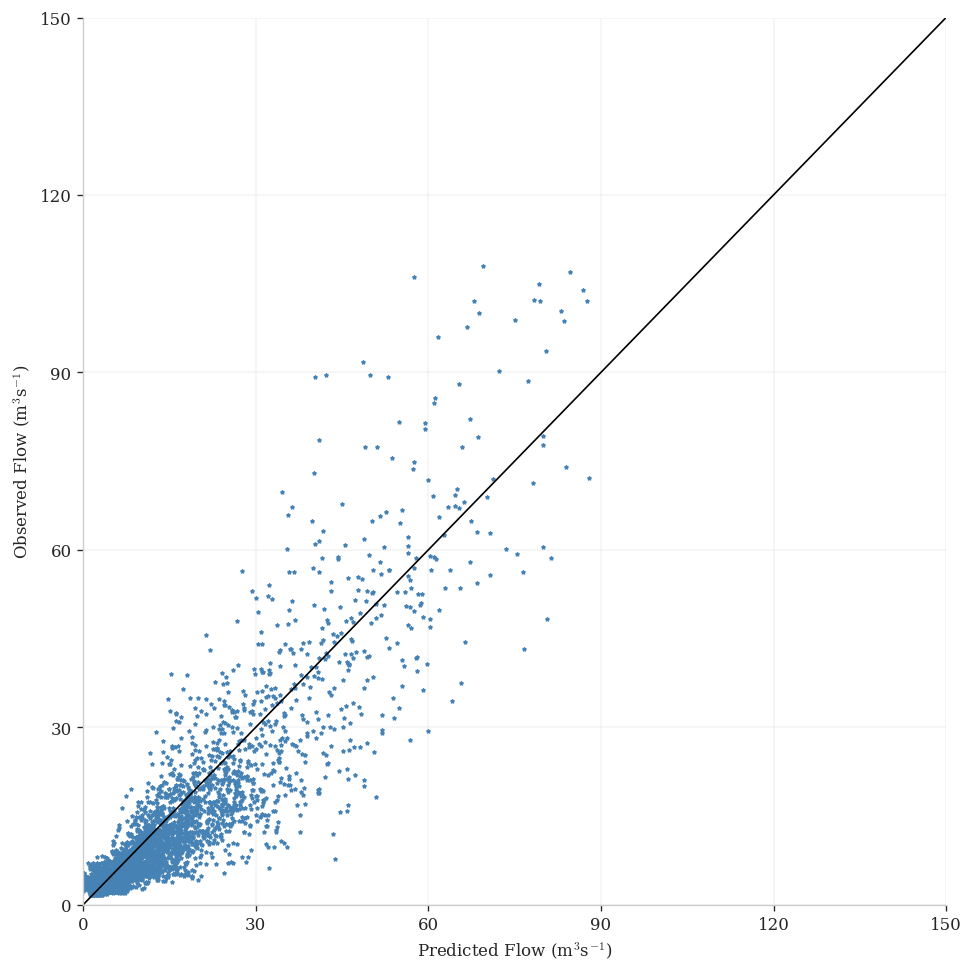

- - - - - - - - - - - - - - -
RMSE: 6.597106646422708
NSE: 0.7813838173429863
RE: 0.910536511125163


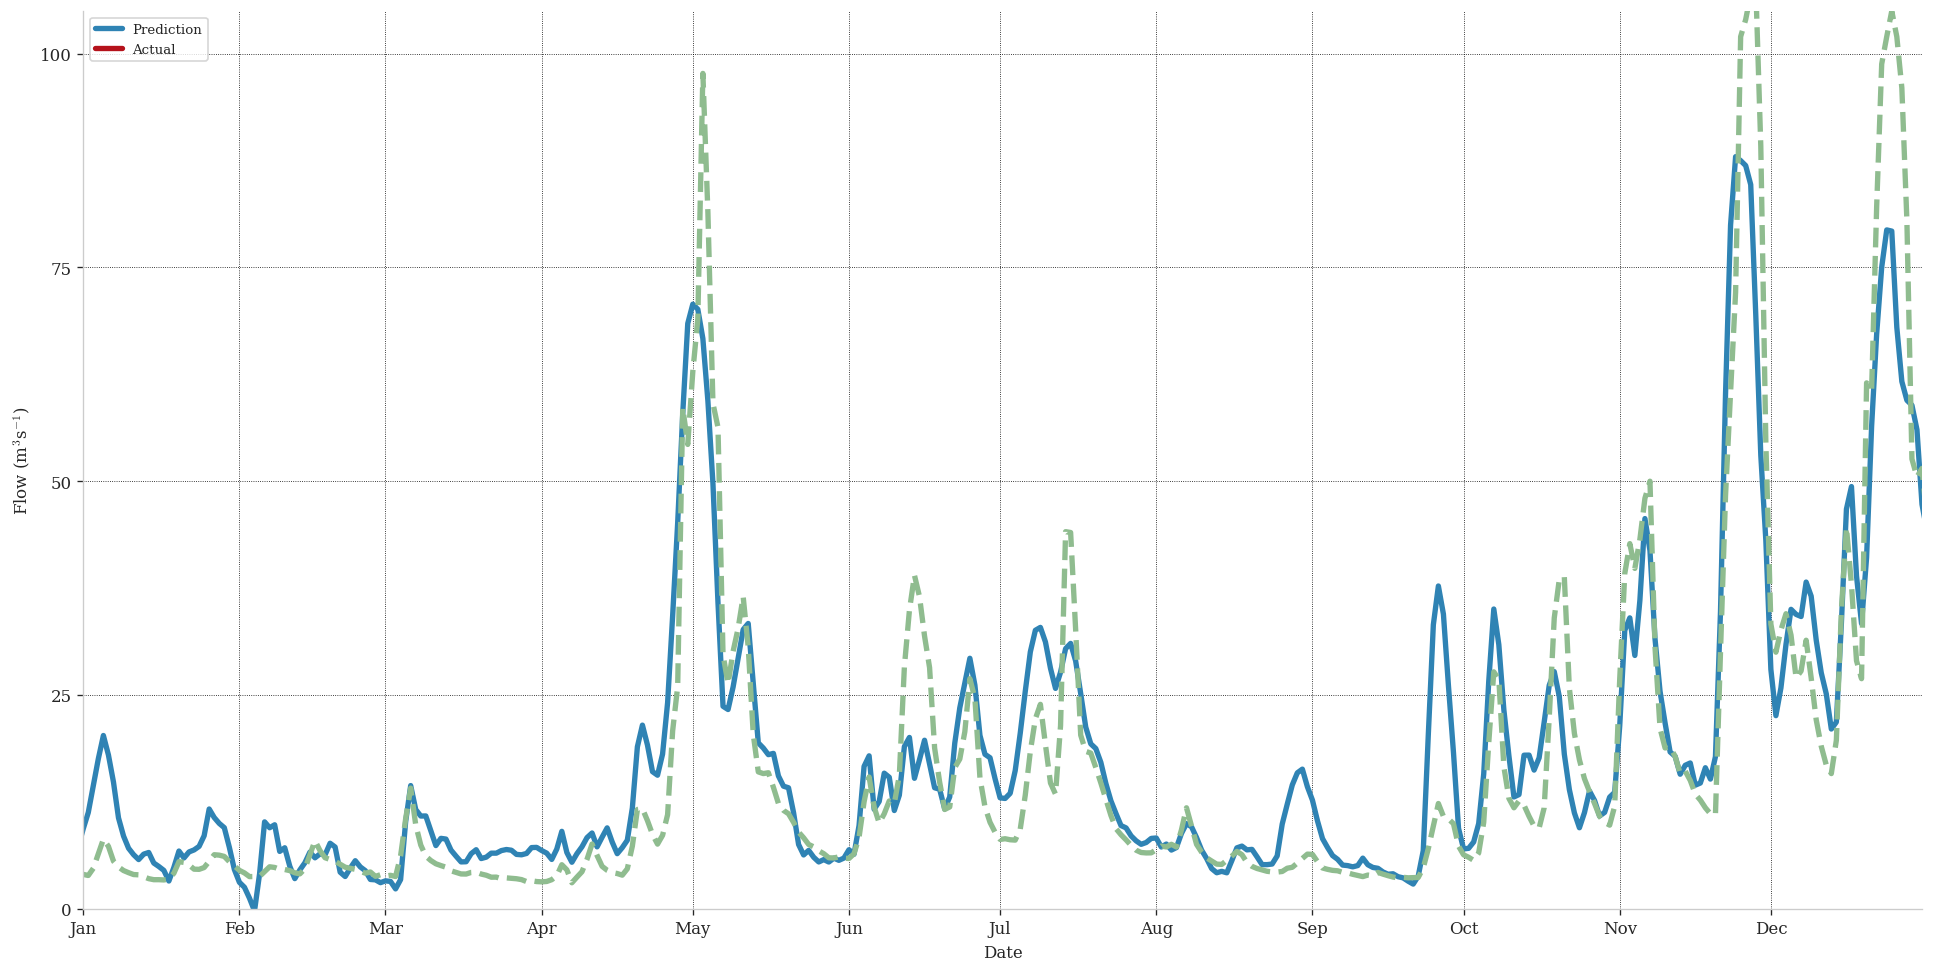

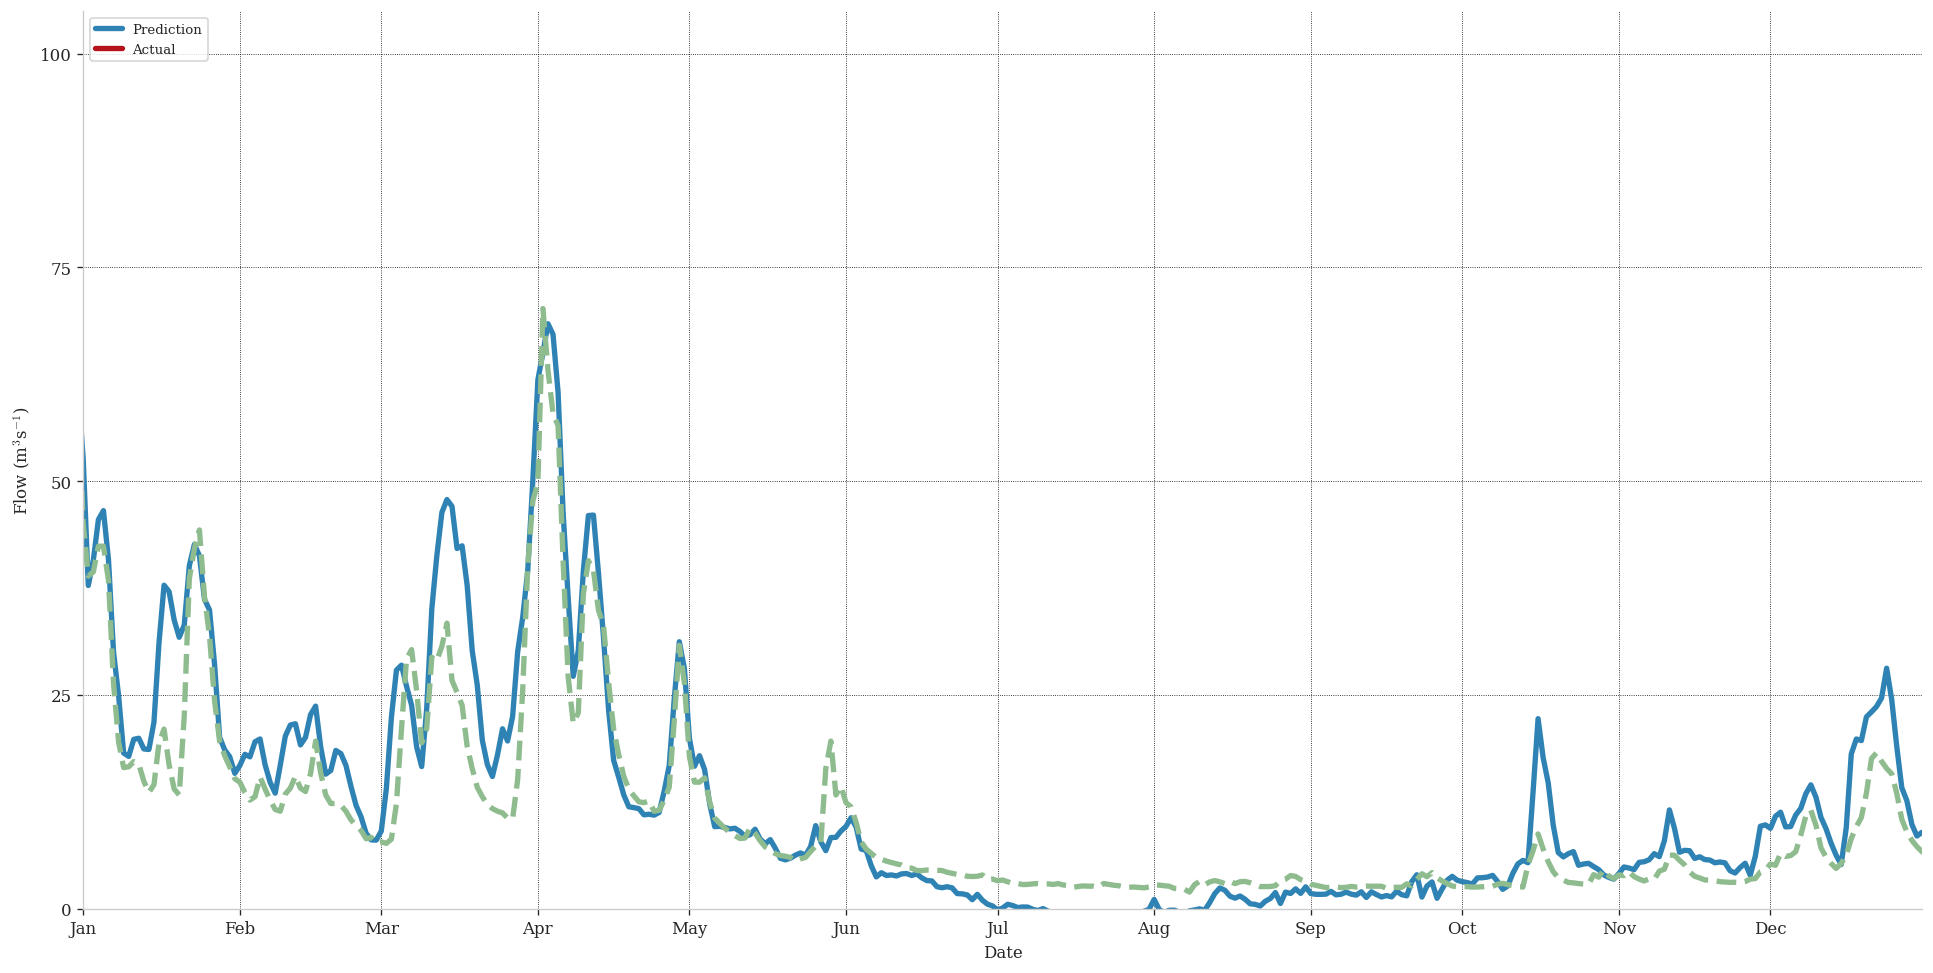

In [176]:
maxflow = 150

# recalculate PSI for alpha=1 and beta=1
psi_RE = ut.psi_distribution(yfull, 'lognorm')

for df in [testrf]:

    psi_df = psi_RE[-(len(ytest)):].squeeze()
    print(psi_df.shape)
    
    strf.scatter_plot(maxflow, df, 'Predicted', 'Flow')
    print('- - - - - - - - - - - - - - -')
    print('RMSE: ' + str(me.RMSE(df['Flow'], df['Predicted'])))
    print('NSE: ' + str(me.R2(df['Flow'], df['Predicted'])))
    print('RE: ' + str(me.RE(df['Flow'], df['Predicted'], psi_df)))
#strf.year_plot(maxflow, rf, 'Predicted', 'Flow', 2007)
strf.year_plot(testrf, 'Predicted', 'Flow', 2012, maxflow)  
strf.year_plot(testrf, 'Predicted', 'Flow', 2018, maxflow)  

In [ ]:
"""
Code below, important things for stability include: the “replace_bijector” lines (they constrain the kernel params to stop them doing silly things), and making sure that you have the JAX-specific line from the first cell of the regression notebook included, bcus if u don’t use float64 numbers, it all breaks
"""
 
class GP_regressor():

    def __init__(self, GP_params = None, tune_hypers = True):

        self.tune_hypers = tune_hypers
        if GP_params is not None:
            self.kernel = GP_params['kernel']
            self.mean_function = GP_params['mean_function']
            self.multiinput = GP_params['multiinput']

        else:
            self.kernel = gpx.kernels.RBF()
            self.mean_function = gpx.mean_functions.Zero()
            self.multiinput = False

        # constrain lengthscales (exact constraint tbd)
        self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64)))#, high=jnp.array(3e1, dtype=jnp.float64)))
        self.kernel = self.kernel.replace_bijector(variance=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))

        self.prior = gpx.gps.Prior(mean_function=self.mean_function, kernel=self.kernel)
        return None

   
    def fit(self, X_train, Y_train):
        self.n_samples_train = X_train.shape[0]
        self.n_features = X_train.shape[1]
        Y_train = Y_train.reshape(-1, 1)
        self.n_targets = Y_train.shape[1]

    # check statistics
    # print(f'x_train: mean = {np.mean(X_train, axis = 0)}, std = {np.std(X_train, axis = 0)}')
    # print(f'y_train: mean = {np.mean(Y_train)}, std = {np.std(Y_train)}')
    # for i, PC in enumerate(X_train.T):
    #       print(PC.shape)
    #       plt.figure()
    #       plt.hist(PC)
    #       plt.show()

        self.D = gpx.Dataset(X=jnp.array(X_train, dtype=jnp.float64), y=jnp.array(Y_train, dtype=jnp.float64))
        
        likelihood = gpx.likelihoods.Gaussian(num_datapoints=self.D.n, obs_stddev=jnp.array([1.0], dtype=jnp.float64)) # here i choose the value of obs_stddev
        likelihood = likelihood.replace_bijector(obs_stddev=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64)))

        posterior = self.prior * likelihood

        if self.tune_hypers:
            negative_mll = gpx.objectives.ConjugateMLL(negative=True)
            negative_mll = jit(negative_mll)

            # hyperparam tuning
            print(likelihood.obs_stddev)
            print(likelihood.obs_stddev.dtype)
            self.opt_posterior, self.history = gpx.fit_scipy(model=posterior, objective=negative_mll, train_data=self.D, max_iters=1000)

            # print(dir(self.opt_posterior))
            # print(self.history)
            print(self.opt_posterior.prior)
            print(self.opt_posterior.likelihood)

        else:
            self.opt_posterior = posterior

 #and then opt_posterior is the thing that u use for the predictions